In [1]:
%matplotlib nbagg
#%load_ext line_profiler
#%load_ext memory_profiler

import jungfrau_utils as ju
import numpy as np
import json
import os, math
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

In [2]:
def Extract_edgepos(sig, back, delays):
    edgePos = []
    Delays_stage = []
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit

        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)

        sig4inter = interp1d(nus_new, sig4invreal[0:2047], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, 50)
        sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1)
        sig6 = np.roll(convolve1d(sig5gaussO0,filter3), -100)

        peak2 = np.argmax(sig5gaussO1 - psen_peak_background) 

        #if (peak2 > 500): 
        edgePos.append(peak2)
        Delays_stage.append(np.round(np.mean(delays),4))
        #sigtraces.append(sig6)
        #peaktraces.append(sig5gaussO1)
        
        #Pump_probe_all.append(Laser_diff)
        #edgeSig.append(sig5)
    return edgePos, Delays_stage

In [72]:
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.special import erf

lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter2 = np.concatenate((signal.tukey(40)[20:40], np.zeros(2027), np.zeros(2047))) # fourier filter for 5um SiN
filter3 = np.concatenate((np.zeros(100), np.ones(100)))
pixelNum = np.arange(0,2047)

#######################################################################################################3

background_from_fit = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-02-27-19:01-psen-background.txt')
psen_peak_background = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-02-27-19:01-psen-peak-background.txt')

px2fs = 1.993008440575784      # new spectrometer, it is ~ 2 px to fs
p0 = 1024

In [7]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[2:3]
patch

['/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_1.json']

In [21]:
channel_list_pp = [channel_Events, 'JF02T09V02',
                  channel_PSEN_signal, channel_PSEN_bkg, channel_delay_topas, channel_Izero117]
channel_list_all = channel_list_pp

roi1 = (7740, 7900, 220, 300) #signal 1
roi2 = (7740, 7900, 400, 480) #bkg 1

roi3 = (5080, 5220, 180, 280) #signal 2
roi4 = (5080, 5220, 300, 400) #bkg 2

Timezero = 215.498720
binsize = 10 # in fs
threshold_low = 5
#threshold_high = 10

#outdir = '/sf/alvra/data/p18938/res/Claudio/'

####################################################################################################3
clock = Clock()
from sfdata import SFScanInfo

for json_file in patch:

    scan = SFScanInfo(json_file)
    Delay_mm = scan.readbacks

    XAS_roi1 = []
    XAS_roi1_on = []
    #Error_XAS_roi1 = []
    XAS_roi2 = []
    XAS_roi2_on = []
    #Error_XAS_roi2 = []
    RIXS_transient_roi1 = []
    RIXS_transient_roi2 = []
    Error_transient_roi1 = []
    Error_transient_roi2 = []
    RIXS_unpumped_roi1 = []
    RIXS_unpumped_roi2 = []
    Error_unpumped_roi1 = []
    Error_unpumped_roi2 = []
    RIXS_pumped_roi1 = []
    RIXS_pumped_roi2 = []
    Error_pumped_roi1 = []
    Error_pumped_roi2 = []
    XAS_transient_roi1=[]
    XES_transient_roi1 =[]
    XAS_transient_roi2=[]
    XES_transient_roi2 =[]
    
    total_transient_roi1 = 0
    total_s_roi1_OFF = 0
    total_s_roi1_ON = 0
    total_binNumber = []

    for i, step in enumerate([scan[0]]):
        check_files_and_data(step)
        
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

        spectrum_ON_roi1 = 0
        spectrum_ON_roi2 = 0
        spectrum_ON_roi3 = 0
        spectrum_ON_roi4 = 0
        spectrum_OFF_roi1 = 0
        spectrum_OFF_roi2 = 0
        spectrum_OFF_roi3 = 0
        spectrum_OFF_roi4 = 0

        resultsPP, results, _, _ = load_data_compact_laser_pump_JF(channel_list_pp, channel_list_all, step, roi1, roi2, roi3, roi4)
        
        Izero_unpump = resultsPP[channel_Izero117].unpump
        Izero_pump = resultsPP[channel_Izero117].pump
        
        sig_pump = resultsPP[channel_PSEN_signal].pump
        sig_unpump = resultsPP[channel_PSEN_signal].unpump
        back_pump = resultsPP[channel_PSEN_bkg].pump
        delay_shot = resultsPP[channel_delay_topas].pump
        
        delay_shot_fs = (delay_shot - Timezero)*2/(3e8*1e3*1e-15)
        
        edgePos, Delays_stage = Extract_edgepos(sig_pump, back_pump, delay_shot_fs)
        Delays_corr = Delays_stage + ((p0 - np.array(edgePos))*px2fs)
        
        images_pump_roi1 = resultsPP['JFroi1'].pump# / Izero_pump[:,None, None]
        images_unpump_roi1 = resultsPP['JFroi1'].unpump# / Izero_unpump[:,None, None]
        images_pump_roi2 = resultsPP['JFroi2'].pump# / Izero_pump[:,None, None]
        images_unpump_roi2 = resultsPP['JFroi2'].unpump# / Izero_unpump[:,None, None]
        images_pump_roi3 = resultsPP['JFroi3'].pump# / Izero_pump[:,None, None]
        images_unpump_roi3 = resultsPP['JFroi3'].unpump# / Izero_unpump[:,None, None]
        images_pump_roi4 = resultsPP['JFroi4'].pump# / Izero_pump[:,None, None]
        images_unpump_roi4 = resultsPP['JFroi4'].unpump# / Izero_unpump[:,None, None]

     #   Delay_mm_single = resultsPP[channel_delay_topas].pump[0]

        images_pump_roi1_thr = images_pump_roi1.copy()
        images_pump_roi1_thr[images_pump_roi1 < threshold_low] = 0
        #images_pump_roi1_thr[images_pump_roi1 > threshold_high] = 0
        images_unpump_roi1_thr = images_unpump_roi1.copy()
        images_unpump_roi1_thr[images_unpump_roi1 < threshold_low] = 0
        #images_unpump_roi1_thr[images_unpump_roi1 > threshold_high] = 0

        images_pump_roi2_thr = images_pump_roi2.copy()
        images_pump_roi2_thr[images_pump_roi2 < threshold_low] = 0
        #images_pump_roi2_thr[images_pump_roi2 > threshold_high] = 0
        images_unpump_roi2_thr = images_unpump_roi2.copy()
        images_unpump_roi2_thr[images_unpump_roi2 < threshold_low] = 0
        #images_unpump_roi2_thr[images_unpump_roi2 > threshold_high] = 0

        images_pump_roi3_thr = images_pump_roi3.copy()
        images_pump_roi3_thr[images_pump_roi3 < threshold_low] = 0
        #images_pump_roi3_thr[images_pump_roi3 > threshold_high] = 0
        images_unpump_roi3_thr = images_unpump_roi3.copy()
        images_unpump_roi3_thr[images_unpump_roi3 < threshold_low] = 0
        #images_unpump_roi3_thr[images_unpump_roi3 > threshold_high] = 0

        images_pump_roi4_thr = images_pump_roi4.copy()
        images_pump_roi4_thr[images_pump_roi4 < threshold_low] = 0
        #images_pump_roi4_thr[images_pump_roi4 > threshold_high] = 0
        images_unpump_roi4_thr = images_unpump_roi4.copy()
        images_unpump_roi4_thr[images_unpump_roi4 < threshold_low] = 0
        #images_unpump_roi4_thr[images_unpump_roi4 > threshold_high] = 0
        
        images_pump_roi1_thr   = images_pump_roi1_thr #/ Izero_pump[:,None, None]
        images_unpump_roi1_thr = images_unpump_roi1_thr #/ Izero_unpump[:,None, None]
        images_pump_roi2_thr   = images_pump_roi2_thr #/ Izero_pump[:,None, None]
        images_unpump_roi2_thr = images_unpump_roi2_thr #/ Izero_unpump[:,None, None]
        images_pump_roi3_thr   = images_pump_roi3_thr #/ Izero_pump[:,None, None]
        images_unpump_roi3_thr = images_unpump_roi3_thr #/ Izero_unpump[:,None, None]
        images_pump_roi4_thr   = images_pump_roi4_thr #/ Izero_pump[:,None, None]
        images_unpump_roi4_thr = images_unpump_roi4_thr #/ Izero_unpump[:,None, None]
        
        spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1)#sum(axis = 0)
        spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1)#.sum(axis = 0)
        spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1)#.sum(axis = 0)
        spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1)#.sum(axis = 0)
        
        ######################### ROI 1 ##############################################
        XES_transient_roi1_ON = spectrum_ON_roi1 - spectrum_ON_roi2
        XES_transient_roi1_OFF = spectrum_OFF_roi1 - spectrum_OFF_roi2
        
        XES_transient_roi1_ON_tolist = ([XES_transient_roi1_ON[:,i] for i in range(XES_transient_roi1_ON.shape[1])])
        XES_transient_roi1_OFF_tolist = ([XES_transient_roi1_OFF[:,i] for i in range(XES_transient_roi1_OFF.shape[1])])
#         XES_transient_roi1_shot = (spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2)
#         XES_transient_roi1_tolist = ([XES_transient_roi1_shot[:,i] for i in range(XES_transient_roi1_shot.shape[1])])
        #XES_transient_roi1_all.append(XES_transient_roi1_shot)
        
        #XES_transient_roi1_all = list(itertools.chain.from_iterable(XES_transient_roi1_all))
 
        binList = np.arange(-500, 1000, binsize)
        Delays_rebinned = np.arange(-500 + binsize/2, 1000 - binsize/2, binsize)

#         s_roi1, binEdges, binNumber = binned_statistic(Delays_corr, XES_transient_roi1_tolist, statistic='sum', bins=binList)
#         total_s_roi1 += s_roi1

        s_roi1_ON, binEdges, binNumber = binned_statistic(Delays_corr, XES_transient_roi1_ON_tolist, statistic='mean', bins=binList)
        s_roi1_OFF, binEdges, binNumber = binned_statistic(Delays_corr, XES_transient_roi1_OFF_tolist, statistic='mean', bins=binList)

        total_s_roi1_ON += np.nan_to_num(s_roi1_ON)
        total_s_roi1_OFF += np.nan_to_num(s_roi1_OFF)
        total_binNumber.append(binNumber)
        
        clear_output(wait=True)
        print ("It took {} to process this file".format(clock.tick()))
        
        break

    total_transient_roi1 = total_s_roi1_ON - total_s_roi1_OFF
    
#     filename_h5 = outdir + json_file.split('/')[-1].split('.')[0] + "_TT_export.h5" 
#     with h5py.File(filename_h5, "w") as file2write:
#         file2write.create_dataset("RIXS_pumped_roi1_TT", data = total_s_roi1_ON)
#         file2write.create_dataset("RIXS_unpumped_roi1_TT", data = total_s_roi1_OFF)
#         file2write.create_dataset("RIXS_transient_roi1_TT", data = total_transient_roi1)
#         #file2write.create_dataset("RIXS_pumped_roi3", data = RIXS_pumped_roi3)
#         #file2write.create_dataset("RIXS_unpumped_roi3", data = RIXS_unpumped_roi3)
#         #file2write.create_dataset("RIXS_transient_roi3", data = RIXS_transient_roi3)   
#         file2write.create_dataset("Delay_rebin", data = Delays_rebinned)
#         #file2write.create_dataset("binNumber", data = total_binNumber)
        
#     print(filename_h5)
    
    #RIXS_transient_roi1.append(total_s_roi1)

    #XES_abs_roi1 = np.abs(total_s_roi1)

#    XAS_transient_roi1.append(np.sum(XES_abs_roi1[50:80]))
#    XAS_transient_roi1_2.append(np.abs(np.sum(total_s_roi1[55:63])) + np.abs(np.sum(total_s_roi1[64:75])))
    
        ######################### ROI 2 ##############################################

#         XAS_roi2.append(np.abs(spectrum_OFF_roi2.sum()))
#         XAS_roi2_on.append(np.abs(spectrum_ON_roi2.sum()))
#         RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
#         Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
#         RIXS_pumped_roi2.append(spectrum_ON_roi2)
#         Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
#         RIXS_transient_roi2.append(spectrum_ON_roi2 - spectrum_OFF_roi2)
#         Error_transient_roi2.append(np.sqrt((np.sqrt(spectrum_ON_roi2))**2 + (np.sqrt(spectrum_OFF_roi2))**2))

#         XES_transient_roi2.append(np.abs(spectrum_ON_roi2 - spectrum_OFF_roi2))
#     #    XES_1D.append(np.sum(XES_transient_roi2, axis = 1))

#         XAS_transient_roi2.append(np.abs(np.sum(RIXS_transient_roi2)))
        #clear_output(wait=True)
        
    
# Energy_eV = np.array(Energy_eV)
# Delay_mm = np.array(Delay_mm)
# XAS_roi1 = np.array(XAS_roi1)
# XAS_roi1_on = np.array(XAS_roi1_on)
# RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
# Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
# RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
# Error_pumped_roi1 = np.array(Error_pumped_roi1)
# RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
# Error_transient_roi1 = np.array(Error_transient_roi1)
# XAS_transient_roi1=np.array(XAS_transient_roi1)
# XES_transient_roi1=np.array(XES_transient_roi1)
# #XES_1D=np.array(XES_1D)
# XAS_roi2 = np.array(XAS_roi2)
# XAS_roi2_on = np.array(XAS_roi2_on)
# RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
# Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
# RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
# Error_pumped_roi2 = np.array(Error_pumped_roi2)
# RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
# Error_transient_roi2 = np.array(Error_transient_roi2)
# XAS_transient_roi2=np.array(XAS_transient_roi2)
# XES_transient_roi2=np.array(XES_transient_roi2)
# #XES_1D=np.array(XES_1D)
    
print ("\nJob done! It took", clock.tock(), "seconds to process all the files")

    
-7

It took 51.4 to process this file

Job done! It took 51.45 seconds to process all the files


In [37]:
images_pump_roi1_thr.sum(axis = 1).shape

(985, 160)

In [76]:
XES_transient_roi1_ON.shape
#len(XES_transient_roi1_ON_tolist)

(985, 160)

In [64]:
XES_transient_roi1_ON_tolist[0]

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  5.7101936,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        6.428775 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  5.730745 ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

In [78]:
print (pixel.shape)
print (Delays_corr.shape)
print (XES_transient_roi1_ON.shape)
print (binList.shape)

(160,)
(985,)
(985, 160)
(150,)


In [79]:
binned_statistic_2d(Delays_corr, pixel, XES_transient_roi1_ON, statistic='mean', bins=[150,160])

/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [67]:
Delays_corr.shape

(985,)

In [66]:
np.shape(XES_transient_roi1_ON)

(985, 160)

In [54]:
s_roi1_ON, binEdges, binNumber = binned_statistic(Delays_corr, XES_transient_roi1_ON_tolist, statistic='mean', bins=binList)

In [60]:
total_s_roi1_ON.shape

(160, 149)

<IPython.core.display.Javascript object>


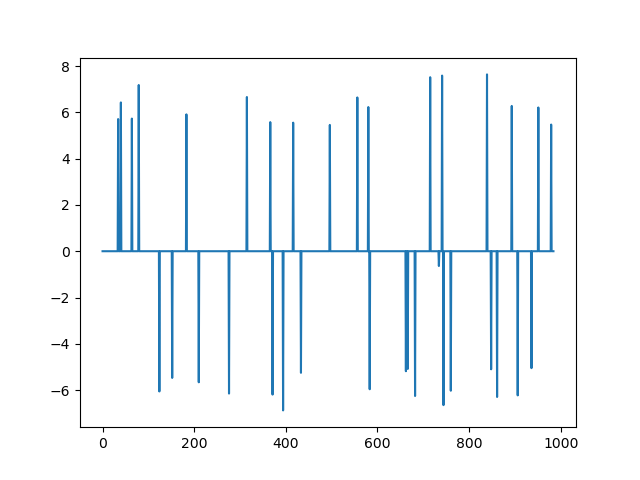

In [65]:
plt.figure()
#plt.plot(images_pump_roi1_thr.sum(axis = 1)[0]- images_pump_roi2_thr.sum(axis = 1)[0])
plt.plot(XES_transient_roi1_ON_tolist[0])
plt.show()

<IPython.core.display.Javascript object>


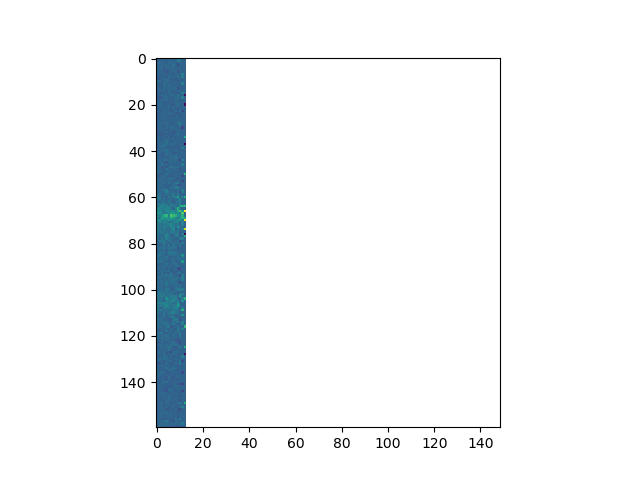

In [24]:
plt.figure()
plt.imshow()
plt.show()

<IPython.core.display.Javascript object>


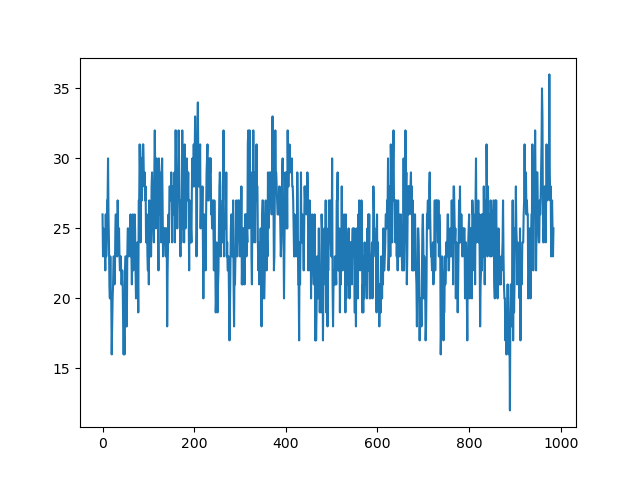

[]

In [158]:
plt.figure()
plt.plot(binNumber)
plt.plot()

In [73]:
test = ([XES_transient_roi1_shot[:,i] for i in range(XES_transient_roi1_shot.shape[1])])

<IPython.core.display.Javascript object>


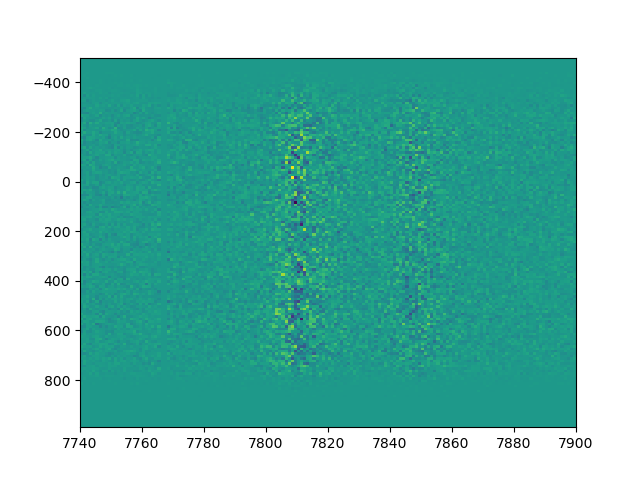

In [80]:
plt.figure()
plt.imshow(total_s_roi1.T, extent=[roi1[0], roi1[1], binList[-1], binList[0]], aspect='auto')
plt.show()

In [71]:
s_roi1.shape

(160, 149)